In [5]:
import numpy as np
from numpy import sin,arcsin, cos,pi
from scipy.linalg import *
from scipy.optimize import fsolve,root
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from matplotlib import animation
from IPython.display import HTML

from IPython.display import YouTubeVideo
YouTubeVideo('-A1w46iqUlE')

def rotA(theta):
    '''This function returns a 2x2 rotation matrix to convert the 
    rotated coordinate to the global coordinate system
    input is angle in radians
        
    Parameters
    ----------
    theta : angle in radians
    
    Returns
    -------
    A : 2x2 array to rotate a coordinate system at angle theta to global x-y
    '''
    A=np.zeros((2,2))
    A=np.array([[np.cos(theta), -np.sin(theta)],
               [np.sin(theta), np.cos(theta)]])
    return A



In [6]:
#Problem 1 - Solving For the Generalized Coordinates
L1 = 0.15
L2 = 0.25
w = 150
theta0= pi/6;
t = 0;

def links(l1 = L1, l2 = L2):
    return l1,l2

def q_slidercrank(t,w,theta0):
    L1,L2 = links()
    theta1 = w*t+theta0
    theta2 = -arcsin((L1/L2)*sin(theta1))
    q = np.zeros(9)
    q[0:2] = -rotA(theta1)@np.array([-L1/2,0])
    q[2] = theta1
    q[3:5]= q[0:2]+rotA(theta1)@np.array([L1/2,0])-rotA(theta2)@np.array([-L2/2,0])
    q[5]  = theta2
    q[6:8]= q[3:5]+rotA(theta2)@np.array([L2/2,0])
    q[8]  = np.arctan(q[7]/q[6]); #Should always equal zero
    return q

def C_slidercrank(q,t,w,theta0):
    l1,l2=links()
    q1 = q[0:3]
    q2 = q[3:6]
    q3 = q[6:9]

    C=np.zeros(9)
    C[0:2] = q1[0:2]+rotA(q1[2])@np.array([-l1/2, 0])
    C[2:4] = q1[0:2]-q2[0:2]+rotA(q1[2])@np.array([l1/2, 0])-rotA(q2[2])@np.array([-l2/2, 0])
    C[4:6] = q2[0:2]-q3[0:2]+rotA(q2[2])@np.array([l2/2, 0])-rotA(q3[2])@np.array([0, 0])
    C[6] = q3[1]
    C[7] = q3[2]
    C[8] = q1[2] - theta0 - w*t
    return C

In [7]:
#Problem 1 - Test to see if the constraint vector is zero at t=0
q = q_slidercrank(t,w,theta0)
C_slidercrank(q,t,w,theta0)


array([0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [8]:
#Solution Set up - Numerical Solver

def A_theta(theta):
    '''This function returns a 2x2 rotation matrix derivative 
    input is angle in radians
        
    Parameters
    ----------
    theta : angle in radians
    
    Returns
    -------
    dAda : 2x2 array derivative of `rotA`
    '''
    dAda=np.array([[-np.sin(theta), -np.cos(theta)],
                   [np.cos(theta), -np.sin(theta)]])
    return dAda

def Cq_pin(qi, qj, ui, uj):
    '''Jacobian of a pinned constraint for planar motion

    Parameters
    ----------
    qi : generalized coordinates of the first body, i [Rxi, Ryi, thetai]
    qj : generalized coordinates of the 2nd body, i [Rxj, Ryj, thetaj]
    ui : position of the pin the body-i coordinate system
    uj : position of the pin the body-j coordinate system
        
    Returns
    -------
    Cq_pin : 2 rows x 6 columns Jacobian of pin constraint Cpin
    '''
    
    Cq_1=np.block([np.eye(2), A_theta(qi[2])@ui[:,np.newaxis] ])
    Cq_2=np.block([-np.eye(2), -A_theta(qj[2])@uj[:,np.newaxis] ])
    Cq_pin=np.block([Cq_1, Cq_2])
    return Cq_pin

def Cq_slidercrank(q,t):
    '''return Jacobian of C_slidercrank(q,t) = dC/dq_i
       |dC1/dR1x dC1/dR1y ... dC9/da3 |
       |dC2/dR1x dC2/dR1y ... dC9/da3 |
       |... ..     .           ...    |
       |            .                 |
       |             .                |
       |dC9/dR1x ...         dC9/da3  |
    Parameters
    ----------
    q : numpy array for 9 generalized coordinates for bodies 1-3 in the slider crank
        q = [q1, q2, q3]
    t : current time
    Returns
    -------
    Cq : 9 rows x 9 columns Jacobian of constraints `C_slidercrank`   
    '''
    l1, l2 = links()
    q1 = q[0:3]
    q2 = q[3:6]
    q3 = q[6:9]
    
    Cq=np.zeros((9,9))
    Cq[0:2, 0:3] = Cq_pin(q1, np.array([0, 0, 0]),np.array([-l1/2, 0]),np.array([0, 0]))[0:2, 0:3]
    Cq[2:4, 0:6] = Cq_pin(q1, q2, np.array([l1/2, 0]), np.array([-l2/2, 0]))
    Cq[4:6, 3:10] = Cq_pin(q2, q3, np.array([l2/2, 0]), np.array([0, 0]))
    Cq[6:8, 7:10] = np.eye(2)
    Cq[8, 2]=1
    return Cq

Text(0, 0.5, 'Angular Displacement (rad)')

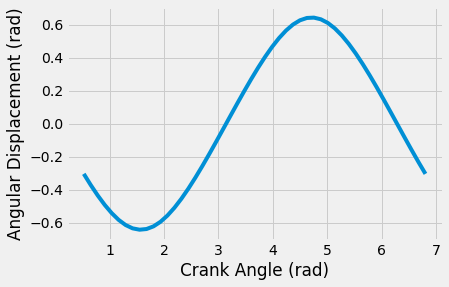

In [9]:
import matplotlib.pyplot as plt
#Problem 2 - Recreate Slider Block Displacment

#Specify System Parameters
t = np.linspace(0, 2*pi/w)

#Determine the initial generalized coordinated
q0 = q_slidercrank(0,w,theta0)

#Allocate Array In Memory
q = np.zeros((len(q0), len(t)))

#Run the Numerical Solver
q[:, 0] = q0
for i,tt in enumerate(t):
    q[:,i]=fsolve(lambda q: C_slidercrank(q,tt,w,theta0),q0,\
                    fprime= lambda q: Cq_slidercrank(q,tt)) # <-- use the Jacobian to speed up solution
    q0=q[:,i]
 
plt.plot(q[2,:],q[5,:]) #Theta 2 vs Theta 1
plt.xlabel('Crank Angle (rad)')
plt.ylabel('Angular Displacement (rad)') 

Text(0, 0.5, 'Block Displacement (m)')

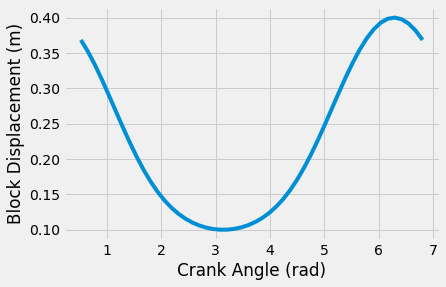

In [10]:
plt.plot(q[2,:],q[6,:]) #Displacement (m) Vs Crank Angle (rad)
plt.xlabel('Crank Angle (rad)')
plt.ylabel('Block Displacement (m)')

In [11]:
#Problem 2 - Define Animations

def plot_shape(shape,dims,q):
    '''
    function to plot a shape based upon the shape dimensions and coordinates
    arguments:
    ----------
    shape: either 'link' or 'base',
            - the link returns two points to plot as a line
            - the base returns one point to plot as a marker
            - if neither 'link' or 'base' are chosen, then 0 is returned and warning printed 
            `choose a \'link\' or \'base\' please`
    dims: the dimensions of the shape
            - the link uses the first value as the length
            - the base ignores the `dims`
    q: generalized coordinates in the form [Rx, Ry, theta]
            - the link returns the center of the link at (Rx, Ry) and oriented at theta
            - the base returns the center at (Rx, Ry) and ignores theta
    returns:
    --------
    datax: coordinates to plot the x-positions
    datay: coordinates to plot the y-positions
            - the link returns array of length 2
            - the base returns array of length 1
    
    '''

    if shape=='link':
        left = rotA(q[2])@np.array([-dims[0]/2, 0])
        right = rotA(q[2])@np.array([dims[0]/2, 0])
        Px=q[0]+np.array([left[0], right[0]])
        Py=q[1]+np.array([left[1], right[1]])
        datax = Px
        datay = Py
        #l,= plt.plot(Px,Py,'o-')
        return datax, datay
    elif shape=='base':
        Px=q[0]
        Py=q[1]
        data = [Px, Py]
        #l,=plt.plot(Px,Py,'s',markersize=20)
        return data
    else:
        print('choose a \'link\' or \'base\' please')
        return 0

def init():
    link1.set_data([], [])
    link2.set_data([], [])
    body3.set_data([], [])
    return (link1, link2, body3)

def animate(i):
    '''function that updates the line and marker data
    arguments:
    ----------
    i: index of timestep
    outputs:
    --------
    link1: the line object plotted in the above ax.plot(...)
    link2: the line object plotted in the above ax.plot(...)
    body3: the marker for the piston in the slider-crank
    '''
    l1, l2 = links()
    datax, datay = plot_shape('link', np.array([l1]), q1[:, i])
    link1.set_data(datax, datay)
    datax, datay = plot_shape('link', np.array([l2]), q2[:, i])
    link2.set_data(datax, datay)
    pinx, piny = plot_shape('base', [], q3[:,i])
    body3.set_data(pinx, piny)
    return (link1, link2, body3, )

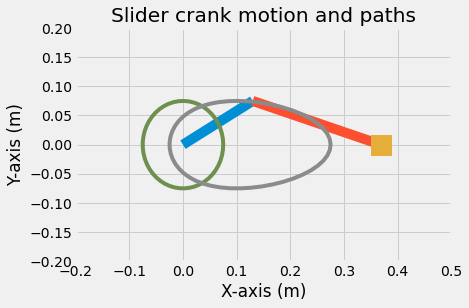

In [12]:
q1 = q[0:3,:]
q2 = q[3:6,:]
q3 = q[6:9,:]
l1, l2 = links()

fig, ax = plt.subplots()
link1, = ax.plot([], [], linewidth = 10)
link2, = ax.plot([], [], linewidth = 10)
body3, = ax.plot([], [], 's', markersize = 20)
path1, = ax.plot(q1[0, :], q1[1, :])
path2, = ax.plot(q2[0, :], q2[1, :])
ax.set_xlim((-0.2,0.5))
ax.set_ylim((-0.2,0.2))
ax.set_xlabel('X-axis (m)')
ax.set_ylabel('Y-axis (m)')
ax.set_title('Slider crank motion and paths')

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=range(0,len(t)), interval=(150*50)/w, 
                               blit=True)

HTML(anim.to_html5_video())

In [13]:
#Problem 2 Define Constraint Derivatives

def Qd_slidercrank(q, dq, t):
    '''return slidercrank Qd = Cq@ddq

    Parameters
    ----------
    q : numpy array for 9 generalized coordinates for bodies 1-3 in the slider crank
        q = [q1, q2, q3]
    t : current time
    Returns
    -------
    Qd : 1D array with length 9     
    '''
    l1, l2 = links()
    q1 = q[0:3]
    q2 = q[3:6]
    q3 = q[6:9]
    dq1 = dq[0:3]
    dq2 = dq[3:6]
    dq3 = dq[6:9]
    
    Qd=np.zeros(9)
    Qd[0:2] = dq1[2]**2*rotA(q1[2])@np.array([-l1/2, 0])
    Qd[2:4] = dq1[2]**2*rotA(q1[2])@np.array([l1/2, 0]) -\
              dq2[2]**2*rotA(q2[2])@np.array([-l2/2, 0])
    Qd[4:6] = dq2[2]**2*rotA(q2[2])@np.array([l2/2, 0])
    Qd[6:9] = 0
    return Qd 

def Ct_slidercrank(q, t,w,theta0):
    '''return slidercrank partial derivative of constraints dC/dt

    Parameters
    ----------
    q : numpy array for 9 generalized coordinates for bodies 1-3 in the slider crank
        q = [q1, q2, q3]
    t : current time
    Returns
    -------
    Ct : 1D array with length 9
    '''
    Ct = np.zeros(9)
    Ct[8] = -w
    return Ct

Text(0, 0.5, 'Angular Velocity (rad/s)')

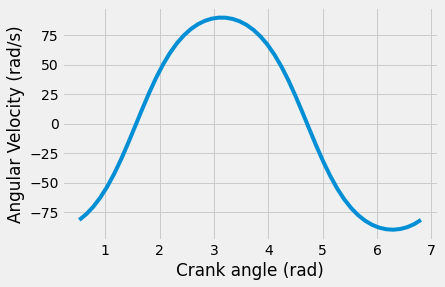

In [14]:
#Problem 2 - Plot Generalized Velocity & Acceleration

#Specify System Parameters
t = np.linspace(0, 2*pi/w)

#Determine the initial generalized coordinated
q0 = q0 = q_slidercrank(0,w,theta0)

#Allocate Array in Computer Memory
q = np.zeros((len(q0), len(t)))
dq = np.zeros(q.shape)
ddq = np.zeros(q.shape)

#Numerical Solver
q[:, 0] = q0
for i, ti in enumerate(t):
    q[:, i] = fsolve(lambda q: C_slidercrank(q, ti,w,theta0),q0,\
                    fprime= lambda q: Cq_slidercrank(q, ti)) # <-- use the Jacobian to speed up solution
    dq[:, i] = np.linalg.solve(Cq_slidercrank(q[:,i], ti), -Ct_slidercrank(q[:, i], ti,w,theta0))
    Qd = Qd_slidercrank(q[:, i], dq[:, i], ti)
    ddq[:, i] = np.linalg.solve(Cq_slidercrank(q[:,i], ti), Qd)
    q0=q[:, i]
    
plt.plot(q[2],dq[5,:]) #Theta 2 Velocity vs crank angle
plt.xlabel('Crank angle (rad)')
plt.ylabel('Angular Velocity (rad/s)')

Text(0, 0.5, 'Velocity (m/s)')

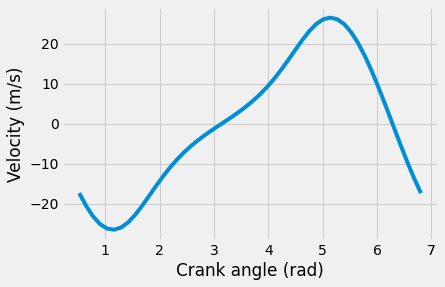

In [15]:
plt.plot(q[2],dq[6,:]) #Velocity of block vs crank angle
plt.xlabel('Crank angle (rad)')
plt.ylabel('Velocity (m/s)')

Text(0, 0.5, 'Angular Acceleration (rad/s^2)')

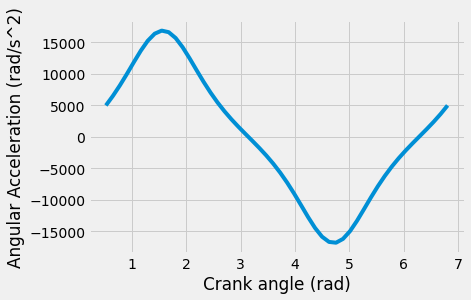

In [16]:
plt.plot(q[2],ddq[5,:]) #Theta 2 Acceleration vs crank angle
plt.xlabel('Crank angle (rad)')
plt.ylabel('Angular Acceleration (rad/s^2)')

Text(0, 0.5, 'Acceleration (m/s^2)')

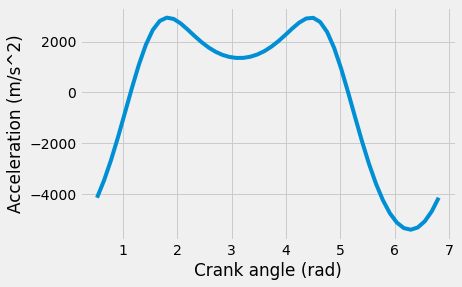

In [17]:
plt.plot(q[2],ddq[6,:]) #Acceleration of block vs crank angle
plt.xlabel('Crank angle (rad)')
plt.ylabel('Acceleration (m/s^2)')